# Exploratory Data Analysis

The objective is to inspect the data, get general understanding of the datasets, check for patterns, understand what preprocessing should be done before the modeling.

Some questions we would like to answer here:

* What's the distribution of engines lifetime in the train sets - and distribution of last time cycle in test sets? 
* What's the distribution of Remaining Useful Life in the test sets?
* What are wear/degradation patterns?
* What are distributions of operational settings?
* What's the difference between engines? 

**Main EDA takeaways:**

* there're patterns of increasing/decreasing trends, indicating degradations, in some of FD00{1,3} sensors time series
* however, the two other datasets should be sclaled per operational condition - there're 6 op conditions, which can be identified with simple clustering
* some sensors time series are constant and are redundant for the modeling
* 50% of units in all the test sets have smaller last time cycle than train sets minimum lifetime

---

The dataset contains a README file with a very good descriptions - let's print it out here:

In [1]:
!cat CMAPSSData/readme.txt

Data Set: FD001
Train trjectories: 100
Test trajectories: 100
Conditions: ONE (Sea Level)
Fault Modes: ONE (HPC Degradation)

Data Set: FD002
Train trjectories: 260
Test trajectories: 259
Conditions: SIX 
Fault Modes: ONE (HPC Degradation)

Data Set: FD003
Train trjectories: 100
Test trajectories: 100
Conditions: ONE (Sea Level)
Fault Modes: TWO (HPC Degradation, Fan Degradation)

Data Set: FD004
Train trjectories: 248
Test trajectories: 249
Conditions: SIX 
Fault Modes: TWO (HPC Degradation, Fan Degradation)



Experimental Scenario

Data sets consists of multiple multivariate time series. Each data set is further divided into training and test subsets. Each time series is from a different engine � i.e., the data can be considered to be from a fleet of engines of the same type. Each engine starts with different degrees of initial wear and manufacturing variation which is unknown to the user. This wear and variation is considered normal, i.e., it is not considered a fault condition. Th

---

# Set Up

In [2]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

%matplotlib inline

In [3]:
!ls CMAPSSData/

Damage Propagation Modeling.pdf test_FD002.txt
RUL_FD001.txt                   test_FD003.txt
RUL_FD002.txt                   test_FD004.txt
RUL_FD003.txt                   train_FD001.txt
RUL_FD004.txt                   train_FD002.txt
readme.txt                      train_FD003.txt
test_FD001.txt                  train_FD004.txt


In [4]:
DATASET_NAMES = ['FD001', 'FD002', 'FD003', 'FD004']
TRAIN_DATA_FILES = [('CMAPSSData/train_{}.txt'.format(x), x) for x in DATASET_NAMES]
TEST_DATA_FILES = [('CMAPSSData/test_{}.txt'.format(x), x) for x in DATASET_NAMES]
TEST_DATA_RUL_FILES = [('CMAPSSData/RUL_{}.txt'.format(x), x) for x in DATASET_NAMES]

OP_SETTING_COLUMNS = ['op_setting_{}'.format(x) for x in range(1, 4)]
SENSOR_COLUMNS = ['sensor_{}'.format(x) for x in range(1, 22)]

---

# Data Inspection

In [5]:
!head -n 2 CMAPSSData/train_FD001.txt

1 1 -0.0007 -0.0004 100.0 518.67 641.82 1589.70 1400.60 14.62 21.61 554.36 2388.06 9046.19 1.30 47.47 521.66 2388.02 8138.62 8.4195 0.03 392 2388 100.00 39.06 23.4190  
1 2 0.0019 -0.0003 100.0 518.67 642.15 1591.82 1403.14 14.62 21.61 553.75 2388.04 9044.07 1.30 47.49 522.28 2388.07 8131.49 8.4318 0.03 392 2388 100.00 39.00 23.4236  


In [6]:
!head -n 2 CMAPSSData/test_FD001.txt

1 1 0.0023 0.0003 100.0 518.67 643.02 1585.29 1398.21 14.62 21.61 553.90 2388.04 9050.17 1.30 47.20 521.72 2388.03 8125.55 8.4052 0.03 392 2388 100.00 38.86 23.3735  
1 2 -0.0027 -0.0003 100.0 518.67 641.71 1588.45 1395.42 14.62 21.61 554.85 2388.01 9054.42 1.30 47.50 522.16 2388.06 8139.62 8.3803 0.03 393 2388 100.00 39.02 23.3916  


In [7]:
def read_data(filename):
    col_names = ['unit', 'time_cycles'] + OP_SETTING_COLUMNS + SENSOR_COLUMNS
    return pd.read_csv(
        filename,
        sep='\s+', header=None,
        names=col_names)

In [8]:
train_FD001 = read_data('CMAPSSData/train_FD001.txt')

In [9]:
print('train_FD001.shape = {}'.format(train_FD001.shape))
train_FD001.head(2)

train_FD001.shape = (20631, 26)


,unit,time_cycles,op_setting_1,op_setting_2,op_setting_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,...,sensor_12,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236


## Read all the datasets

In [10]:
train = []
for dataset in TRAIN_DATA_FILES:
    dataset_df = read_data(dataset[0])
    dataset_df['dataset'] = dataset[1]
    train.append(dataset_df)
    
train = pd.concat(train, ignore_index=True)

print('train.shape = {}'.format(train.shape))
train.head(2)

train.shape = (160359, 27)


,unit,time_cycles,op_setting_1,op_setting_2,op_setting_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,...,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21,dataset
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,FD001
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,FD001


In [11]:
test = []
for dataset in TEST_DATA_FILES:
    dataset_df = read_data(dataset[0])
    dataset_df['dataset'] = dataset[1]
    test.append(dataset_df)

test = pd.concat(test, ignore_index=True)

print('test.shape = {}'.format(test.shape))

test.shape = (104897, 27)


In [12]:
test_rul = []
for dataset in TEST_DATA_RUL_FILES:
    dataset_df = pd.read_csv(
        dataset[0], 
        header=None, 
        names=['rul']
    )
    dataset_df['dataset'] = dataset[1]
    test_rul.append(dataset_df)

test_rul = pd.concat(test_rul, ignore_index=True)
test_rul['unit'] = test[['unit', 'dataset']].drop_duplicates()['unit'].values

print(f'test_rul.shape = {test_rul.shape}')

test_rul.head(2)

test_rul.shape = (707, 3)


,rul,dataset,unit
0,112,FD001,1
1,98,FD001,2


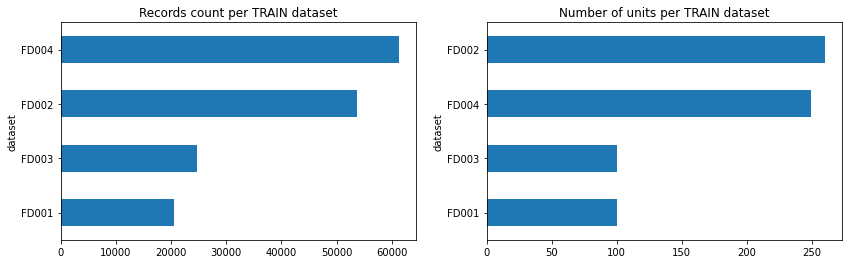

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(14, 4))
train.groupby('dataset').size().sort_values().plot.barh(ax=ax[0])
ax[0].set_title('Records count per TRAIN dataset')

train.groupby('dataset')['unit'].max().sort_values().plot.barh(ax=ax[1])
ax[1].set_title('Number of units per TRAIN dataset')

fig.show()

# What's the distribution of engines lifetime in the train sets - and distribution of last time cycle in test sets? 

**Train sets - Observations:**

Lifetimes of `FD00{1, 2}` seems to have the same distributions and be generated by the same process. That can be explained by their failure type - both datasets contain engines only with "HPC Degradation".

However, `FD00{3, 4}` have higher right tail corresponding to longer engines lifetimes. These dataset contain engines with "HPC Degradation and Fan Degradation".

FD00{1, 2} AVG lifetime - 206 cycles and MAX - 378 vs. FD00{3, 4} AVG lifetime - 245 cycles and MAX - 543

**Test sets - Observations:**

* there're much more short lifetimes in the test set:
    * almost **50% of units in all the test sets have smaller last time cycle than train sets minimum lifetime**
* test sets lifetimes are shorter, on average, on 70 time cycles compared to the train sets

In [14]:
train_units_lifetime = train.groupby(['dataset', 'unit'])['time_cycles'].max().reset_index()
test_units_lifetime = test.groupby(['dataset', 'unit'])['time_cycles'].max().reset_index()


test_units_lifetime['dataset'] = 'test_' + test_units_lifetime['dataset']
test_units_lifetime['set'] = 'test'
train_units_lifetime['dataset'] = 'train_' + train_units_lifetime['dataset']
train_units_lifetime['set'] = 'train'

units_lifetime = train_units_lifetime.append(test_units_lifetime, ignore_index=True)

In [15]:
units_lifetime.groupby('dataset')['time_cycles'].describe()

,count,mean,std,min,25%,50%,75%,max
dataset,,,,,,,,
test_FD001,100.0,130.960000,53.593479,31.0,88.75,133.5,164.25,303.0
test_FD002,259.0,131.239382,63.085925,21.0,76.50,132.0,168.00,367.0
test_FD003,100.0,165.960000,86.891773,38.0,105.00,148.0,208.00,475.0
test_FD004,248.0,166.185484,91.606522,19.0,102.00,153.5,218.50,486.0
train_FD001,100.0,206.310000,46.342749,128.0,177.00,199.0,229.25,362.0
train_FD002,260.0,206.765385,46.782198,128.0,174.00,199.0,230.25,378.0
train_FD003,100.0,247.200000,86.483840,145.0,189.75,220.5,279.75,525.0
train_FD004,249.0,245.979920,73.110800,128.0,190.00,234.0,290.00,543.0


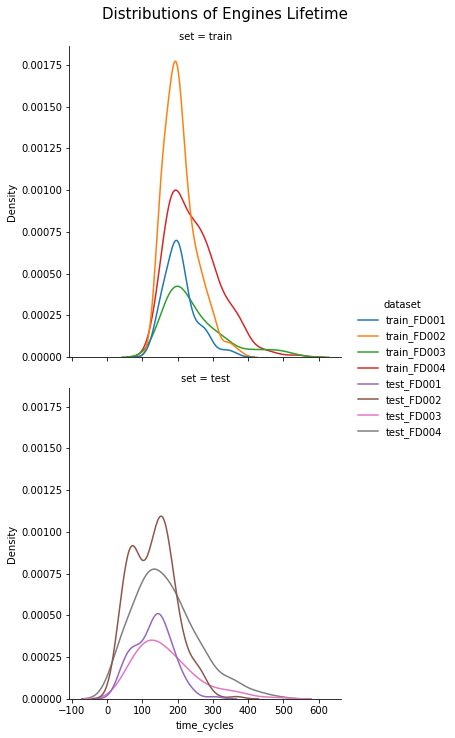

In [16]:
ax = sns.displot(data=units_lifetime, x='time_cycles', hue='dataset', kind='kde', row='set')
ax.figure.suptitle('Distributions of Engines Lifetime', y=1.02, size=15);

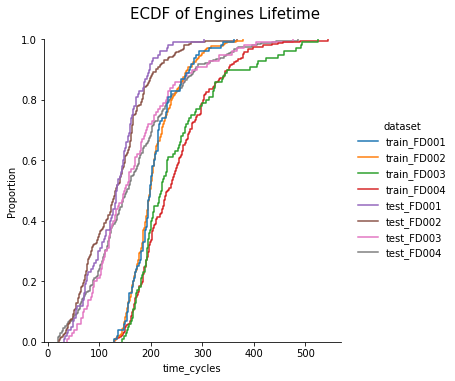

In [17]:
ax = sns.displot(data=units_lifetime, x='time_cycles', hue='dataset', kind='ecdf')
ax.figure.suptitle('ECDF of Engines Lifetime', y=1.05, size=15);

# What's the distribution of Remaining Useful Life in the test sets?

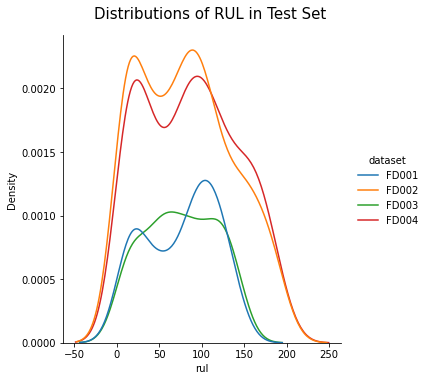

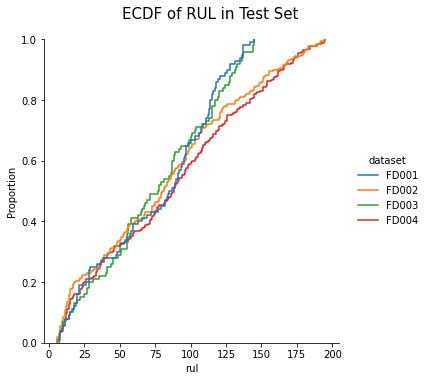

In [18]:
ax = sns.displot(data=test_rul, x='rul', hue='dataset', kind='kde')
ax.figure.suptitle('Distributions of RUL in Test Set', y=1.05, size=15);

ax = sns.displot(data=test_rul, x='rul', hue='dataset', kind='ecdf');
ax.figure.suptitle('ECDF of RUL in Test Set', y=1.05, size=15);

# What are wear/degradation patterns?

**Observations:**

* clear patterns of increasing/decreasing trends in some of FD00{1, 3} sensors time seris
* no visual patterns in FD00{2, 4} time series - these datasets contain 6 operational conditions, this might explain the variance. Hence, need to try to scale per condition - **see the section below**.
* some sensors time series are constant - can be removed before the modeling part
* sensors noise should be considered

In [19]:
def plot_all_units_per_dataset(df, columns=SENSOR_COLUMNS):
    datasets = df['dataset'].unique()
    fig, ax = plt.subplots(21, 4, figsize=(26, 70))
    for i, dataset_name in enumerate(datasets):
        dataset_df = df[df['dataset'] == dataset_name]
        for j, sensor in enumerate(columns):
            dataset_df.pivot(index='time_cycles', columns='unit', values=sensor) \
                .plot(ax=ax[j, i], legend=None, alpha=0.5)
            ax[j, i].set_title('{} - {}, across all units'.format(dataset_name, sensor))
            ax[j, i].grid(color='grey', linewidth=0.3)
    fig.tight_layout()
    plt.show()

In [20]:
# plot_all_units_per_dataset(train)

![](figures/sensors_across_all_units_original.png)

In [21]:
def plot_all_units(df, dataset_name, columns=SENSOR_COLUMNS):
    dataset_df = df[df['dataset'] == dataset_name]
    for sensor in columns:
        fig, ax = plt.subplots(figsize=(16, 8))
        dataset_df.pivot(index='time_cycles', columns='unit', values=sensor) \
            .plot(ax=ax, legend=None, alpha=0.5)
        ax.set_title('{} - {}, across all units'.format(dataset_name, sensor))
        ax.grid(color='grey', linewidth=0.3)
        plt.show()
        
def plot_unit_sensors_ts(unit, df, features=SENSOR_COLUMNS, dataset_name='train_FD001', per_sensor=False):
    unit_df = df[(df['unit'] == unit) & (df['dataset'] == dataset_name)]
    unit_df.index = unit_df['time_cycles']
    unit_df = unit_df[features]

    scaler = StandardScaler()
    unit_sensor_sc = pd.DataFrame(scaler.fit_transform(unit_df), 
                                  columns=features)

    fig, ax = plt.subplots(figsize=(14, 6))
    unit_sensor_sc.plot(ax=ax)
    ax.grid(color='grey', linewidth=0.3)
    ax.set_title('{}, Unit: {} (scaled sensor measurements)'.format(dataset_name, unit), loc='left')
    plt.show()

    if per_sensor:
        for sensor in features:
            fig, ax = plt.subplots(figsize=(16, 6))
            unit_df[sensor].plot(ax=ax, label=sensor)
            ax.legend()
            ax.grid(color='grey', linewidth=0.3)
            ax.set_title('{}, Unit: {}'.format(dataset_name, unit), loc='left')
            plt.show()

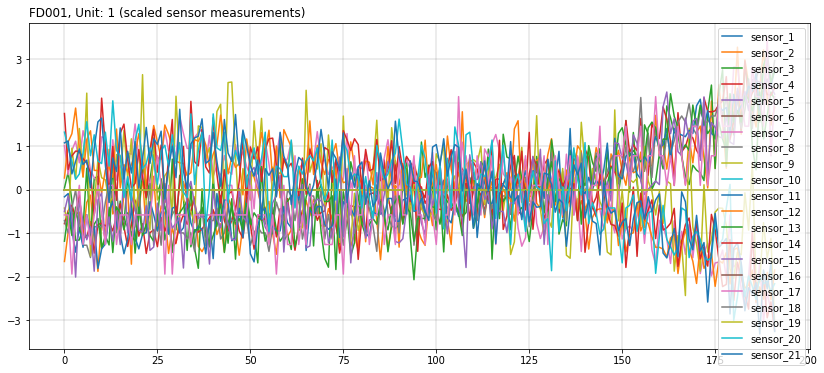

In [22]:
plot_unit_sensors_ts(unit=1, df=train, dataset_name='FD001', per_sensor=False)

# What are distributions of operational settings?

**Observations:**


* dataset pairs of FD00{1,3}, FD00{2,4} have identical distributions of operational settings
* FD00{2,4} have 6 clusters of op conditions (aligns with `Conditions: SIX` from the README file); the clusters have zero within cluster variance 
* no clusters of operational conditions in FD001 or FD003 

See the figures below:

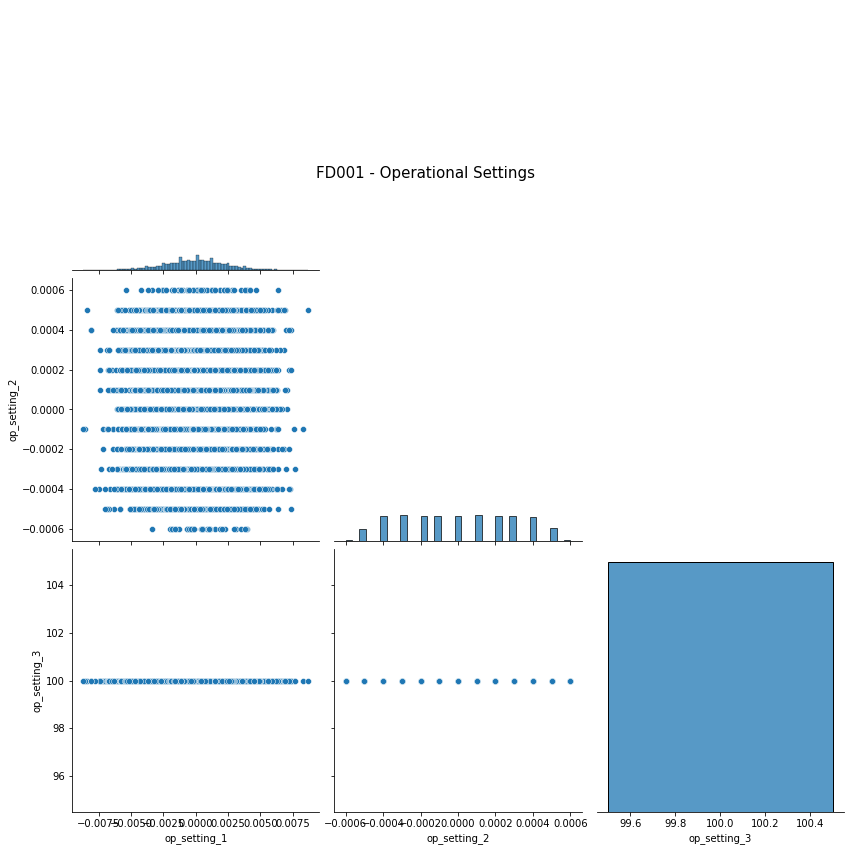

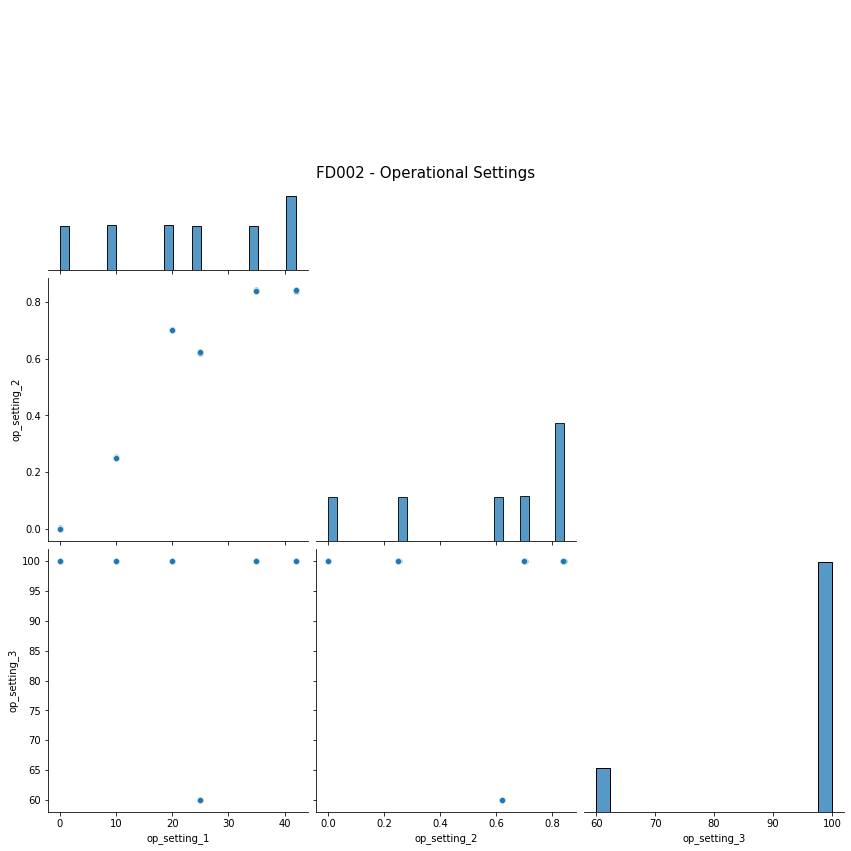

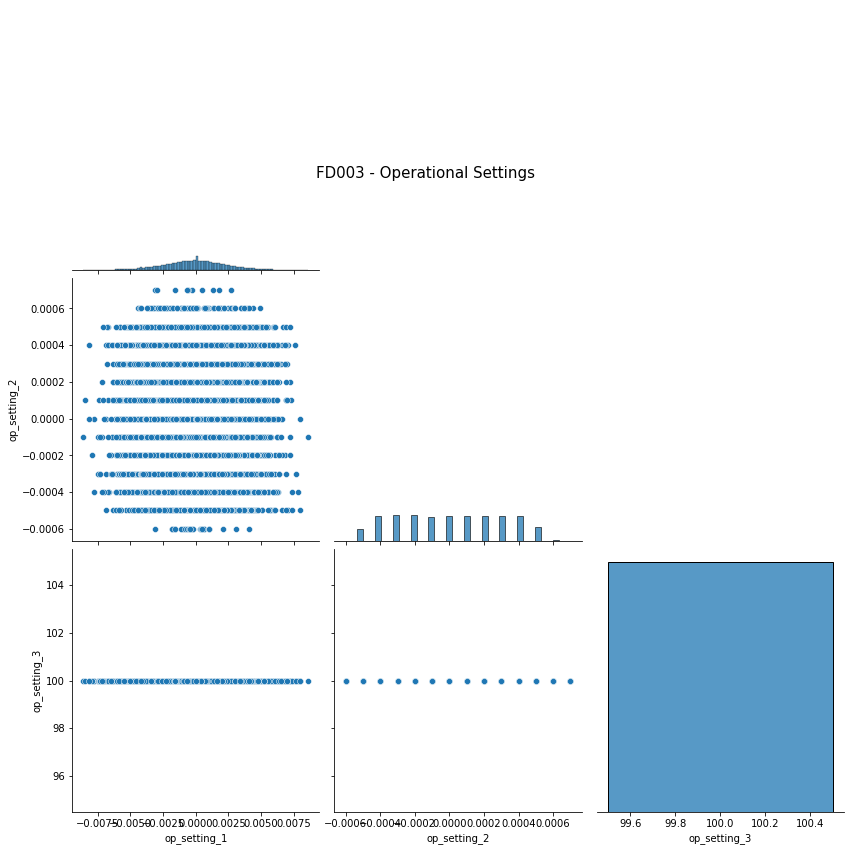

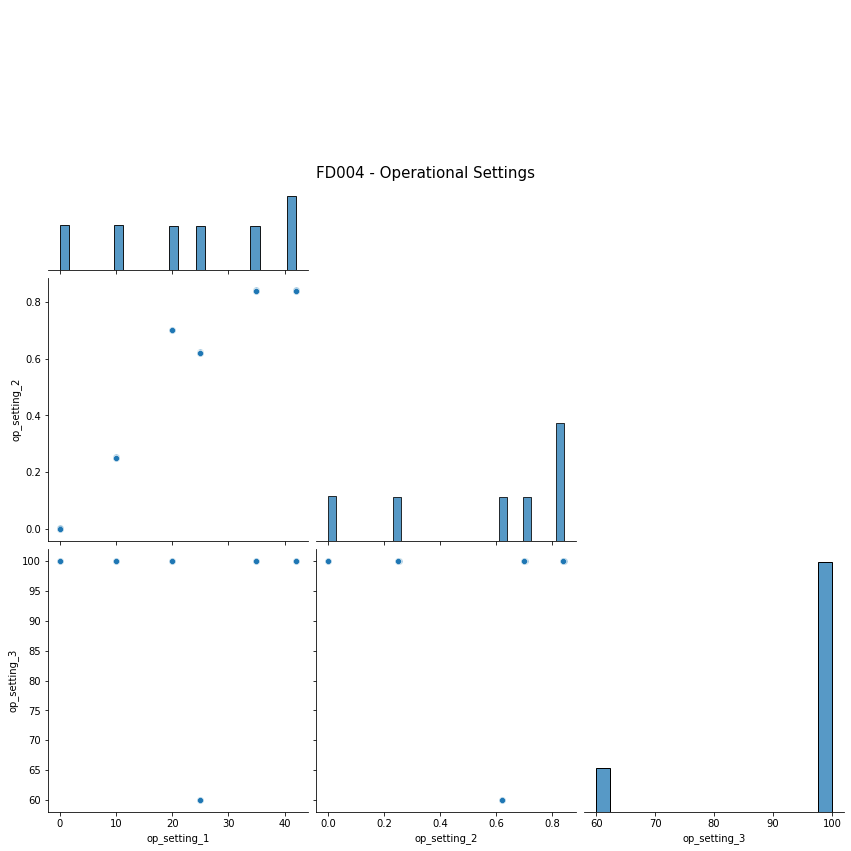

In [23]:
for dataset_name in DATASET_NAMES:
    fig = sns.pairplot(train[train['dataset'] == dataset_name][OP_SETTING_COLUMNS], 
                       corner=True, height=4)
    fig.fig.suptitle(f'{dataset_name} - Operational Settings', y=0.8, size=15)
    plt.show()

## Scaling per operational condition (FD002 and FD004)

Comparing sensors' time series plots of FD00{2,4} vs FD00{1,3} - we couldn't see such a clear degradation patterns in FD00{2,4} as in {1,3}, however, there're 6 operational conditions in {2,4} which should explain the variance.

We would like to try scaling the sensors time series within operational conditions. For that we do:

1. cluster operational settings into 6 clusters:
    * Do Scaling before the clustering - to normlize the difference in scales
    * KMeans with `n_clusters` 6
    * get clusters labels
2. scale within every operational conditions cluster

For that, it's convenient to write a Transformer inherited from sklearn TransformerMixin:

In [24]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler


class ScalePerOpSetting(BaseEstimator, TransformerMixin):
    def __init__(self, n_conditions=6, op_settings_col=OP_SETTING_COLUMNS, sensors_col=SENSOR_COLUMNS):
        self.n_conditions = n_conditions
        self.op_settings_col = op_settings_col
        self.sensors_col = SENSOR_COLUMNS

    def fit(self, X):
        # scale before clustering
        self.kmeans_scaler = StandardScaler()
        X_sc = self.kmeans_scaler.fit_transform(X[self.op_settings_col])
        
        # cluster operational settings into `n_conditions` clusters
        self.kmeans = KMeans(n_clusters=self.n_conditions)
        self.kmeans.fit(X_sc)
        
        X_t = X.copy()
        X_t['op_set_cluster'] = self.kmeans.predict(X_sc)
        
        # scale per cluster
        self.scalers = {}
        for cluster in range(self.n_conditions):
            scaler = StandardScaler()
            scaler.fit(X_t[X_t['op_set_cluster'] == cluster][self.sensors_col])
            self.scalers[cluster] = scaler

        return self
    
    def transform(self, X):
        X_t = X.copy()
        X_t['op_set_cluster'] = self.kmeans.predict(
            self.kmeans_scaler.transform(X[self.op_settings_col]))

        set_columns = ['dataset', 'unit', 'time_cycles', 'op_set_cluster'] + self.op_settings_col
        df = pd.DataFrame()
        for cluster in range(self.n_conditions):
            cluster_X = X_t[X_t['op_set_cluster'] == cluster]
            scaler = self.scalers[cluster]
            sensors_sc = scaler.transform(cluster_X[self.sensors_col])

            df = df.append(pd.concat([cluster_X[set_columns].reset_index(drop=True), 
                                      pd.DataFrame(sensors_sc, columns=self.sensors_col)
                                     ], axis=1, ignore_index=True), 
                           ignore_index=True)

        df.columns = set_columns + SENSOR_COLUMNS
        df = df.sort_values(['unit', 'time_cycles']).reset_index(drop=True)
        return df
        

In [25]:
train_sc = train[train['dataset'].isin(['FD001', 'FD003'])].reset_index(drop=True)

for dataset_name in ['FD002', 'FD004']:
    scaler = ScalePerOpSetting(n_conditions=6)
    df_sc = scaler.fit_transform(train[train['dataset'] == dataset_name])
    
    train_sc = train_sc.append(df_sc, ignore_index=True)
    
train_sc = train_sc.sort_values(['dataset', 'unit', 'time_cycles'])

We can see that 5 out of 6 clusters have very similar proportion of records, but 1 cluster got 10% more records - see the ratios for FD002:

In [26]:
pd.value_counts(train_sc[train_sc['dataset'] == 'FD002']['op_set_cluster'], normalize=True)

3.0    0.250339
0.0    0.151082
4.0    0.150598
1.0    0.149631
5.0    0.149501
2.0    0.148849
Name: op_set_cluster, dtype: float64

Same true for FD004:

In [27]:
pd.value_counts(train_sc[train_sc['dataset'] == 'FD004']['op_set_cluster'], normalize=True)

5.0    0.251351
0.0    0.150827
3.0    0.150598
1.0    0.149586
2.0    0.149211
4.0    0.148427
Name: op_set_cluster, dtype: float64


So, now the picture changed and we can see the patterns in FD00{2, 4} sensors time series we couldn't see before:

In [28]:
# plot_all_units_per_dataset(train_sc)

![](figures/sensors_across_all_units_sc.png)

# What's the difference between engines?

**Observations:**

* From the README file we know that `The engine is operating normally at the start of each time series...`
* We can see the difference between engines sensors time series - the figure below shows the 2 of the most distinct engines across a couple of selected features
* **This suggests we might need to scale the sensors time series with respect to start of every individual engines time series** 
* Scaling with respect to individual engines starting values allows us to bring all the engines time series to the same scale

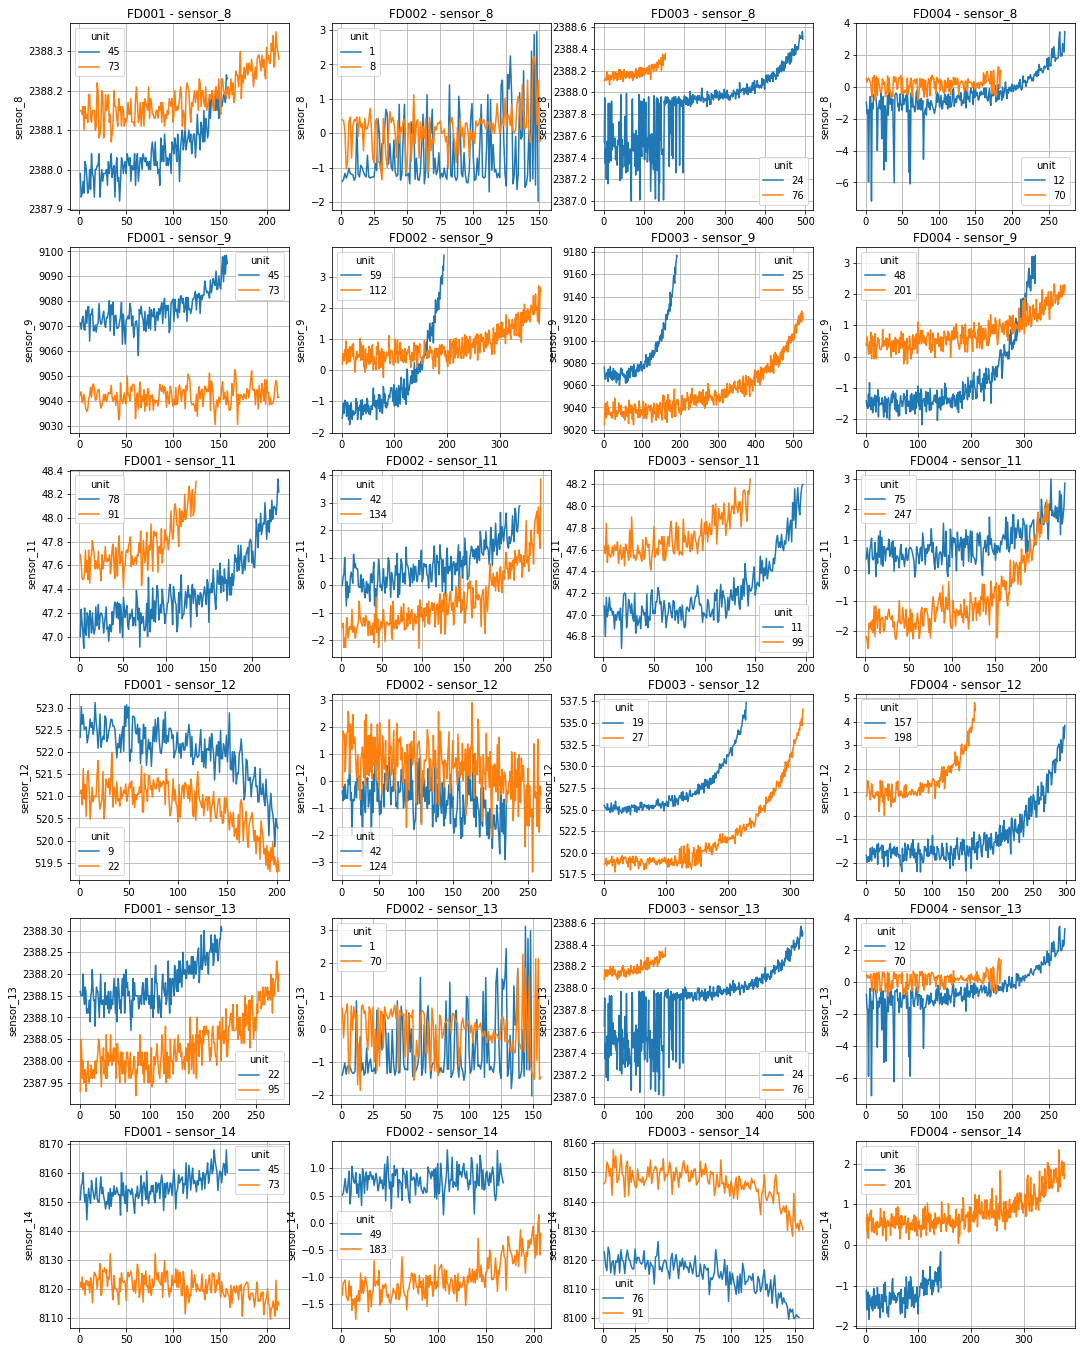

In [29]:
SELECTED_SENSORS = [
    'sensor_8', 'sensor_9', 'sensor_11', 'sensor_12', 'sensor_13', 'sensor_14'
]

first_avg_values = (train_sc[train_sc['time_cycles'] <= 20]
    .groupby(by=['dataset', 'unit'])[SELECTED_SENSORS]
    .mean()
    .reset_index()
)


fig, ax = plt.subplots(len(SELECTED_SENSORS), len(DATASET_NAMES), figsize=(18, 24))
for i, dataset in enumerate(DATASET_NAMES):
    for j, sensor in enumerate(SELECTED_SENSORS):
        avg_sorted = (first_avg_values[first_avg_values['dataset'] == dataset]
                      .sort_values(sensor))
        engine_a, engine_b = avg_sorted['unit'].iloc[0], avg_sorted['unit'].iloc[-1]
        sns.lineplot(
            data=train_sc[
                    (train_sc['dataset'] == dataset) 
                    & (train_sc['unit'].isin([engine_a, engine_b]))
            ],
            x='time_cycles', y=sensor, hue='unit', palette='tab10',
            ax=ax[j, i]
        )
        ax[j, i].set_xlabel('')
        ax[j, i].set_title(f'{dataset} - {sensor}')
        ax[j, i].grid()
fig.show()

In [30]:
class ScalePerEngine(BaseEstimator, TransformerMixin):
    '''
    Scale individual engines time series with respect to its start.
    Substract firts `n_first_cycles` AVG values from time series. 
    '''
    def __init__(self, n_first_cycles=20, sensors_columns=SENSOR_COLUMNS):
        self.n_first_cycles = n_first_cycles
        self.sensors_columns = sensors_columns
    
    def fit(self, X):
        return self

    def transform(self, X):
        init_sensors_avg = X[X['time_cycles'] <= self.n_first_cycles] \
            .groupby(by=['unit'])[self.sensors_columns] \
            .mean() \
            .reset_index()

        X_t = X[X['time_cycles'] > self.n_first_cycles].merge(
            init_sensors_avg,
            on=['unit'], how='left', suffixes=('', '_init_v')
        )

        for SENSOR in self.sensors_columns:
            X_t[SENSOR] = X_t[SENSOR] - X_t['{}_init_v'.format(SENSOR)]

        drop_columns = X_t.columns.str.endswith('init_v')
        return X_t[X_t.columns[~drop_columns]]

In [31]:
scaler = ScalePerEngine()
fd001_scaled = scaler.fit_transform(train_sc[train_sc['dataset'] == 'FD001'])

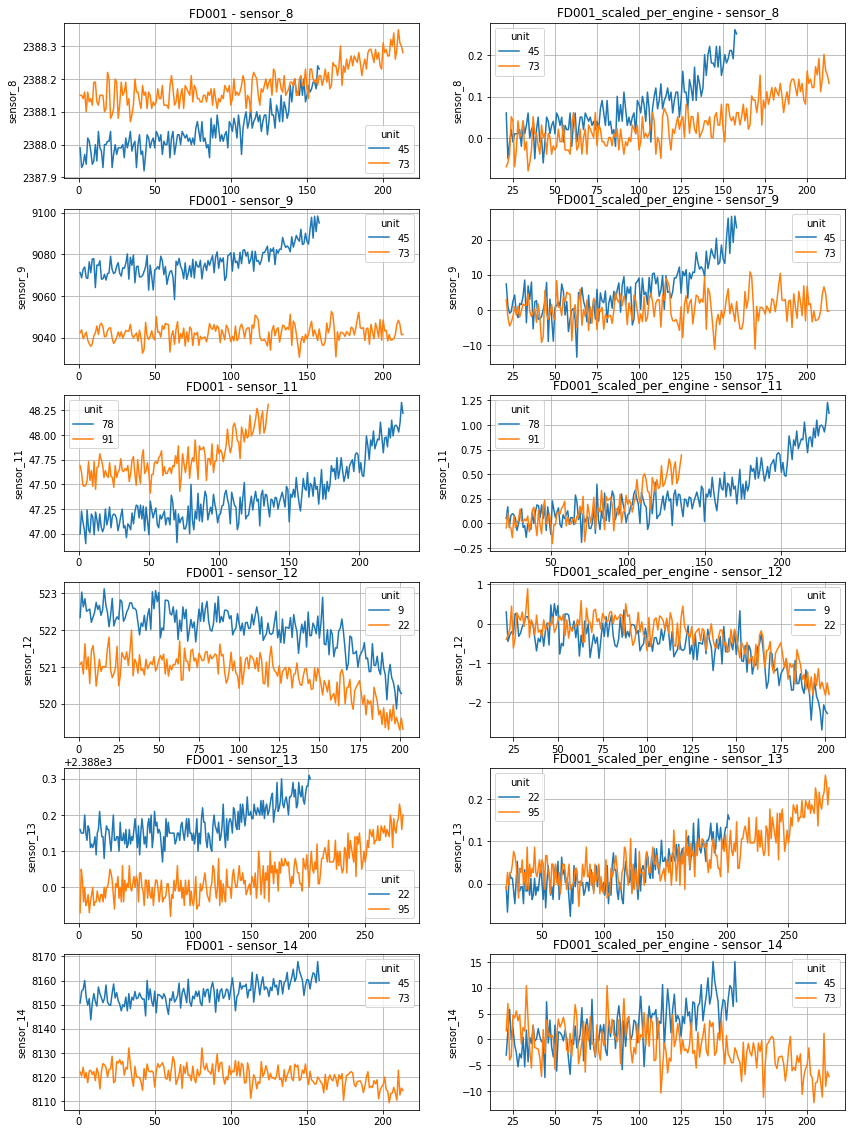

In [32]:
dataset = 'FD001'
datasets_info = ['FD001', 'FD001_scaled_per_engine']

fig, ax = plt.subplots(len(SELECTED_SENSORS), 2, figsize=(14, 20))
for j, sensor in enumerate(SELECTED_SENSORS):
        avg_sorted = (first_avg_values[first_avg_values['dataset'] == dataset]
                      .sort_values(sensor))
        engine_a, engine_b = avg_sorted['unit'].iloc[0], avg_sorted['unit'].iloc[-1]
        for i, df in enumerate([train_sc, fd001_scaled]):
            sns.lineplot(
                data=df[
                        (df['dataset'] == dataset) 
                        & (df['unit'].isin([engine_a, engine_b]))
                ],
                x='time_cycles', y=sensor, hue='unit', palette='tab10',
                ax=ax[j, i]
            )
            ax[j, i].set_xlabel('')
            ax[j, i].set_title(f'{datasets_info[i]} - {sensor}')
            ax[j, i].grid()
fig.show()

---